In [6]:
import cv2
import numpy as np
import seaborn as sns
from time import time
from tqdm import tqdm
import torch
import h5py

from line_junction_utils import *
from robust_line_based_estimator.line_matcher import LineMatcher
from robust_line_based_estimator.vp_matcher import vp_matching
from robust_line_based_estimator.visualization import plot_images, plot_lines, plot_color_line_matches, plot_matches

In [7]:
# Parameters
matcher_type = "sold2"
dataset_path = "/media/hdd3tb/datasets/scannet/scannet_test_images"
pair_list = "/media/hdd3tb/datasets/scannet/scannet_pairs.txt"
output_path = "."
threshold = 10 # Threshold in pixels
visualize = 5

In [8]:
# Initializing the line matcher
if matcher_type == "lbd":
    # LSD+LBD matcher
    matcher = LineMatcher(line_detector='lsd', line_matcher='lbd')
else:
    # SOLD2 matcher
    conf = {
        'sold2': {
            'ckpt_path': '../third_party/SOLD2/pretrained_models/sold2_wireframe.tar',
            'device': 'cpu'
        }
    }
    matcher = LineMatcher(line_detector='sold2', line_matcher='sold2', conf=conf)

In [9]:
def processingScene(dataset_path, source_img_name, dest_img_name, K1, K2, P, matcher, linefile_path, matchfile_path, threshold, visualize = False):
    cnt = 0

    img0 = cv2.imread(f"{dataset_path}/{source_img_name}.jpg", 0)
    img1 = cv2.imread(f"{dataset_path}/{dest_img_name}.jpg", 0)

    ## Detecting line segments in the first image
    features0_segments = read_h5(f"img-{source_img_name}-line-segments", linefile_path)
    features0_descs = read_h5(f"img-{source_img_name}-descriptor", linefile_path)
    features0_ms_lines = read_h5(f"img-{source_img_name}-ms_lines", linefile_path)
    features0_scale_factor = read_h5(f"img-{source_img_name}-scale", linefile_path)
    if features0_segments is None:
        features0 = matcher.detect_and_describe_lines(img0)
        if matcher.matcher == "lbd":
            append_h5({f"img-{source_img_name}-line-segments": features0["line_segments"],
                f"img-{source_img_name}-descriptor": features0["descriptor"], 
                f"img-{source_img_name}-ms_lines": convert_ms_lines(features0["ms_lines"])}, 
                linefile_path)
        elif matcher.matcher == "sold2":
            append_h5({f"img-{source_img_name}-line-segments": features0["line_segments"],
                f"img-{source_img_name}-descriptor": features0["descriptor"],
                f"img-{source_img_name}-scale": features0["scale_factor"] }, 
                linefile_path)
    else:
        if matcher.matcher == "lbd":
            features0 = { "line_segments": features0_segments, 
                "descriptor": features0_descs,
                "ms_lines": parse_ms_lines(features0_ms_lines) }
        elif matcher.matcher == "sold2":
            features0 = { "line_segments": torch.tensor(features0_segments), 
                "descriptor": torch.tensor(features0_descs), 
                "scale_factor": torch.tensor(features0_scale_factor) }
        
    # Detecting line segments in the second image
    features1_segments = read_h5(f"img-{dest_img_name}-line-segments", linefile_path)
    features1_descs = read_h5(f"img-{dest_img_name}-descriptor", linefile_path)
    features1_ms_lines = read_h5(f"img-{dest_img_name}-ms_lines", linefile_path)
    features1_scale_factor = read_h5(f"img-{dest_img_name}-scale", linefile_path)
    if features1_segments is None:
        features1 = matcher.detect_and_describe_lines(img1)
        if matcher.matcher == "lbd":
            append_h5({f"img-{dest_img_name}-line-segments": features1["line_segments"],
                f"img-{dest_img_name}-descriptor": features1["descriptor"], 
                f"img-{dest_img_name}-ms_lines": convert_ms_lines(features1["ms_lines"])}, 
                linefile_path)
        elif matcher.matcher == "sold2":
            append_h5({f"img-{dest_img_name}-line-segments": features1["line_segments"],
                f"img-{dest_img_name}-descriptor": features1["descriptor"],
                f"img-{dest_img_name}-scale": features1["scale_factor"] }, 
                linefile_path)
    else:
        if matcher.matcher == "lbd":
            features1 = { "line_segments": features1_segments, 
                "descriptor": features1_descs,
                "ms_lines": parse_ms_lines(features1_ms_lines) }
        elif matcher.matcher == "sold2":
            features1 = { "line_segments": torch.tensor(features1_segments), 
                "descriptor": torch.tensor(features1_descs), 
                "scale_factor": torch.tensor(features1_scale_factor) }

    ## Matching
    m_lines0 = read_h5(f"{source_img_name}-{dest_img_name}-m_lines0", matchfile_path)
    m_lines1 = read_h5(f"{source_img_name}-{dest_img_name}-m_lines1", matchfile_path)
    if m_lines0 is None:
        _, m_lines0, m_lines1 = matcher.match_lines(img0, img1, features0, features1)
        append_h5({f"{source_img_name}-{dest_img_name}-m_lines0": m_lines0,
            f"{source_img_name}-{dest_img_name}-m_lines1": m_lines1}, 
            matchfile_path)

    # Get all possible line junctions
    keypoints1, keypoints2 = get_line_junctions(m_lines0, m_lines1)

    # Normalize the obtained keypoints by the camera matrix
    if keypoints1.shape[0] > 0:
        kp1n = normalize_keypoints(keypoints1[:, [1, 0]], K1).astype(np.float64)
        kp2n = normalize_keypoints(keypoints2[:, [1, 0]], K2).astype(np.float64)

    # Normalizing the threshold by the camera matrices
    normalized_threshold = threshold / (0.25 * (K1[0, 0] + K1[1, 1] + K2[0, 0] + K2[1, 1]))

    # Composing the projection matrices from the rotations and translations
    P1 = np.concatenate([np.identity(3), np.zeros((3, 1))], axis=1)
    P2 = P

    # Checking each point's consistency with the camera poses by
    # triangulating them and, then, calculating the re-projection error.
    # for point_idx in range(kp1n.shape[0]):
    if keypoints1.shape[0] > 0:
        # s_errors = sampson_errors(keypoints1, keypoints2, K1 @ P1, K2 @ P2)
        points3d, status = polynomial_triangulation(kp1n, P1, kp2n, P2)
        errors = reprojection_errors(keypoints1[:, [1, 0]], keypoints2[:, [1, 0]], points3d, K1 @ P1, K2 @ P2)
        inlier_mask = errors < threshold      

    if visualize:
        if keypoints1.shape[0] > 0:
            print(f"Point number = {kp1n.shape[0]}")    
            print(f"Inlier number = {inlier_mask.sum()}")

            # Select points that fall inside the images
            points_inside1 = (keypoints1[:,1] >= 0) & (keypoints1[:,1] < img0.shape[1]) & (keypoints1[:,0] >= 0) & (keypoints1[:,0] < img0.shape[0])
            points_inside2 = (keypoints2[:,1] >= 0) & (keypoints2[:,1] < img1.shape[1]) & (keypoints2[:,0] >= 0) & (keypoints2[:,0] < img1.shape[0])
            points_inside = points_inside1 & points_inside2 & inlier_mask

        # Plot the matches
        plot_images([img0, img1], ['Keypoints 0', 'Keypoints 1'])
        plot_color_line_matches([m_lines0[:, :, [1, 0]], m_lines1[:, :, [1, 0]]])

        if keypoints1.shape[0] > 0:
            tmpKps1 = np.stack((keypoints1[points_inside, 1], keypoints1[points_inside, 0]), axis=1)
            tmpKps2 = np.stack((keypoints2[points_inside, 1], keypoints2[points_inside, 0]), axis=1)
            plot_matches(tmpKps1, tmpKps2)


## Line detection and description

Point number = 6693
Inlier number = 2962
Point number = 3135
Inlier number = 501
Point number = 942
Inlier number = 108
Point number = 4050
Inlier number = 293
Point number = 3385
Inlier number = 997


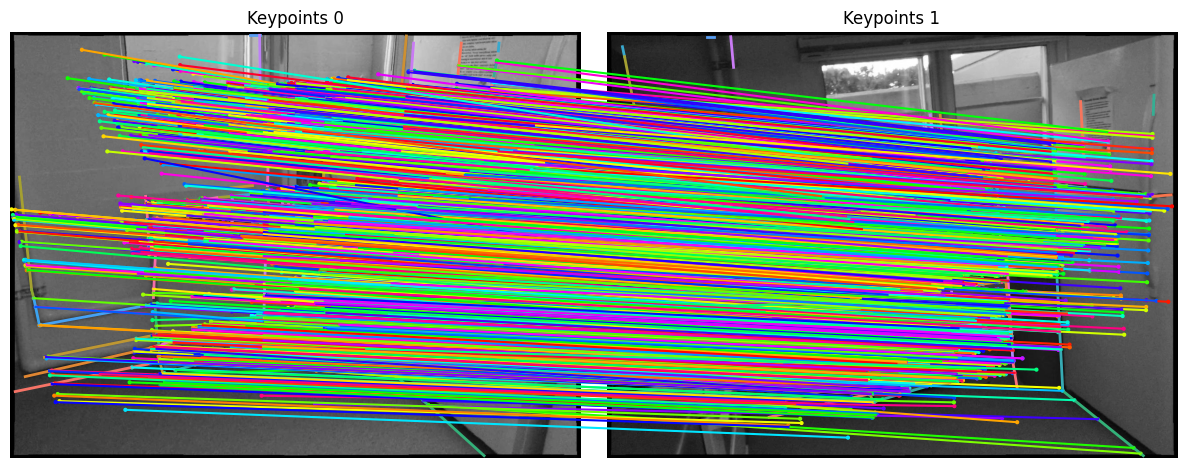

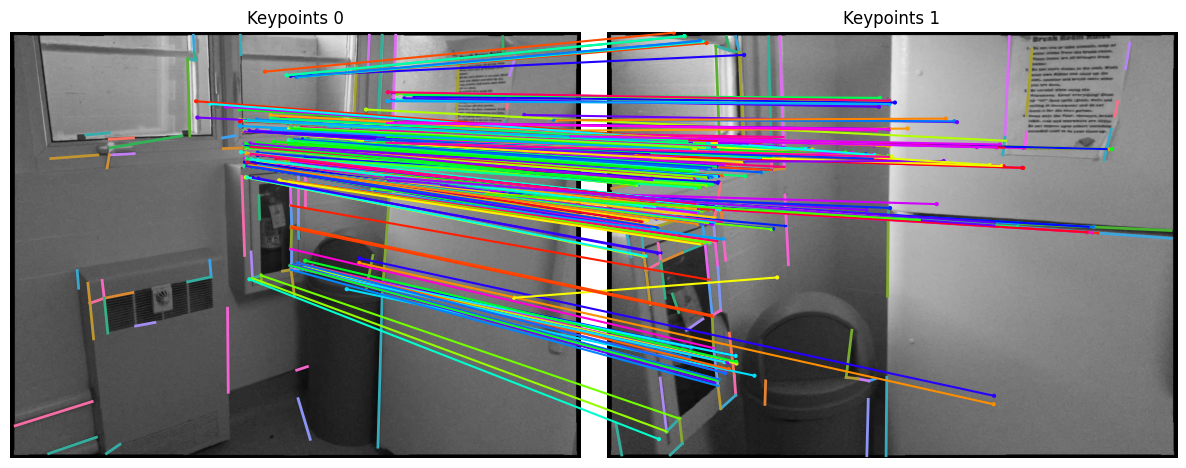

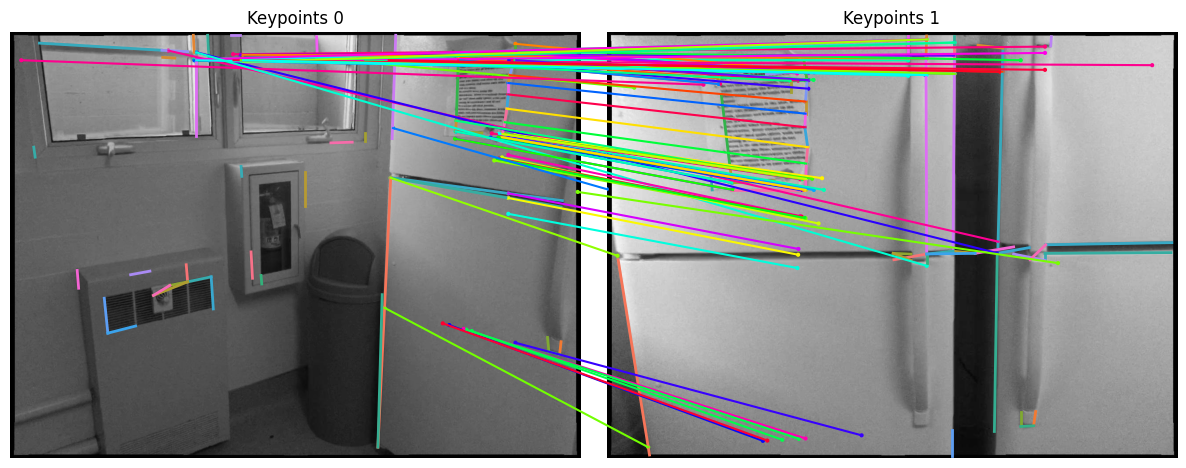

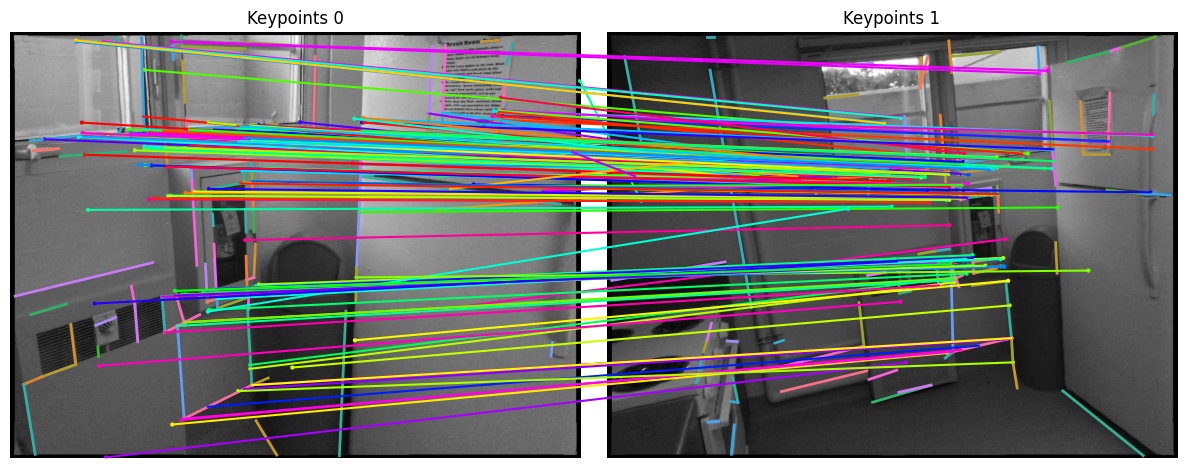

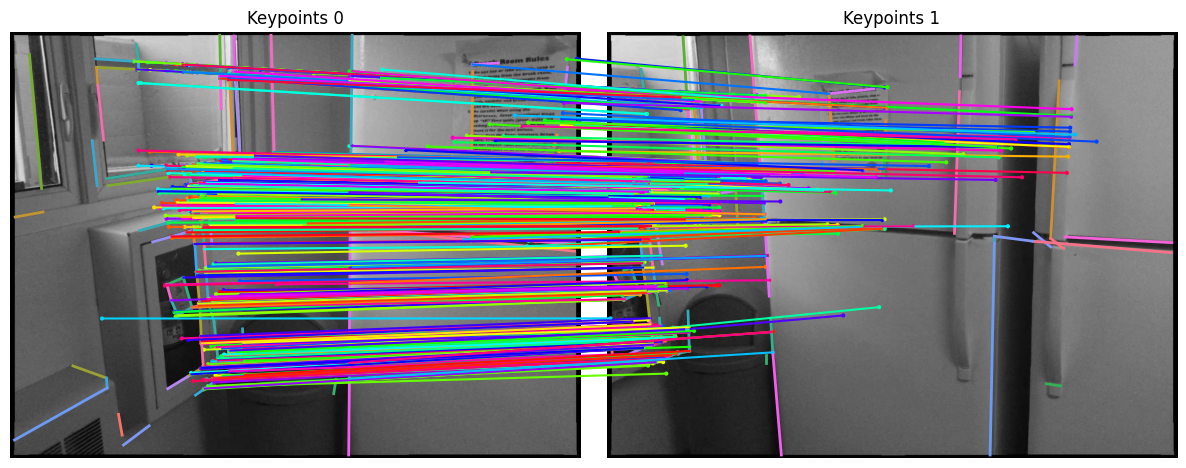

In [10]:
with open(pair_list, "r") as file:
    pair_number = 0
    while True:
        # Get next line from file
        line = file.readline()

        # If line is empty
        # end of file is reached
        if not line:
            break

        items = line.split(" ")
        pair_number += 1

        source_img_name = items[0][11 : 11 + 12] + "_" + items[0][29 : 29 + 12] 
        dest_img_name = items[1][11 : 11 + 12] + "_" + items[1][29 : 29 + 12] 
        K1 = np.resize(np.array(items[4:13]).astype(np.float64), (3, 3))
        K2 = np.resize(np.array(items[13:22]).astype(np.float64), (3, 3))
        P = np.resize(np.array(items[22:]).astype(np.float64), (4, 4))[:3,:]

        # Iterating through the image pairs in the scene
        processingScene(
            dataset_path,
            source_img_name, 
            dest_img_name, 
            K1,
            K2, 
            P, 
            matcher,
            f"{output_path}/lines_{matcher_type}_scannet.h5", 
            f"{output_path}/matches_{matcher_type}_scannet.h5", 
            threshold,
            visualize = pair_number <= visualize)

        if visualize > 0 and pair_number > visualize:
            break
    